ToDo: finalize Delta hedge

# Binomial Tree

In [31]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.2
S = 100
T = 1.0
N = 50
K = 99
r = 0.06

In [32]:
def buildTree (S, vol , T, N):
    dt = T/N
    matrix = np.zeros((N+1, N+1))
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    for i in np.arange(N+1):        # iterate over rows
        for j in np.arange(i+1):    # iterate over columns
        # Hint : express each cell as a combination of up and down moves
            matrix[i, j] = S*(u**j * d**(i-j))

    return matrix 

In [33]:
print(buildTree(S, sigma, T, N))

[[100.           0.           0.         ...   0.           0.
    0.        ]
 [ 97.2111984  102.86880693   0.         ...   0.           0.
    0.        ]
 [ 94.50017095 100.         105.81991439 ...   0.           0.
    0.        ]
 ...
 [ 25.72659203  27.22385766  28.80826287 ... 388.70286396   0.
    0.        ]
 [ 25.00912842  26.46463828  28.00485757 ... 377.86271228 399.85399865
    0.        ]
 [ 24.31167344  25.72659203  27.22385766 ... 367.32487093 388.70286396
  411.32503788]]


In [34]:
def valueOptionMatrix (tree, T, N, r, K, vol, call=True):

    dt = T/N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        if call:
            tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)
        else:
            tree[rows - 1, c] = max(0, K-S) # Should be higher than strike price, or worthless (Call case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r*dt) * (p*up+(1-p)*down)

    return tree


In [35]:
tree = buildTree(S, sigma, T, N)
print("EU Call Price: ", valueOptionMatrix(tree, T, N, r, K, sigma)[0,0])
tree = buildTree(S, sigma, T, N)
print("EU Put Price: ", valueOptionMatrix(tree, T, N, r, K, sigma, False)[0,0])
# Cross referenced with this site, results are correct
# https://www.optionseducation.org/toolsoptionquotes/optionscalculator

EU Call Price:  11.546434850755073
EU Put Price:  4.781123675595919


In [36]:
def valueOptionMatrixAmerican (tree, T, N, r, K, vol, call=True):

    dt = T/N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        if call:
            tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)
        else:
            tree[rows - 1, c] = max(0, K-S) # Should be lower than strike price to be in money (Put case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            if call:
                tree[i, j] = max(tree[i, j] - K , (np.exp(-r*dt) * (p*up+(1-p)*down)))  # Is it better to use continuation value or to excercise now
            else:
                tree[i, j] = max(K - tree[i, j] , (np.exp(-r*dt) * (p*up+(1-p)*down)))

    return tree

In [37]:
tree = buildTree(S, sigma, T, N)
print("US Call Price: ", valueOptionMatrixAmerican(tree, T, N, r, K, sigma)[0,0])
tree = buildTree(S, sigma, T, N)
print("US Put Price: ", valueOptionMatrixAmerican(tree, T, N, r, K, sigma, False)[0,0])
# Cross referenced with this site, results are correct
# https://www.optionseducation.org/toolsoptionquotes/optionscalculator

US Call Price:  11.546434850755073
US Put Price:  5.34776349841765


# Experiments

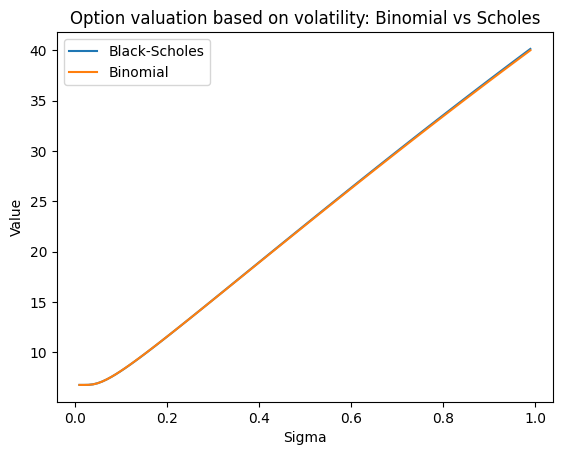

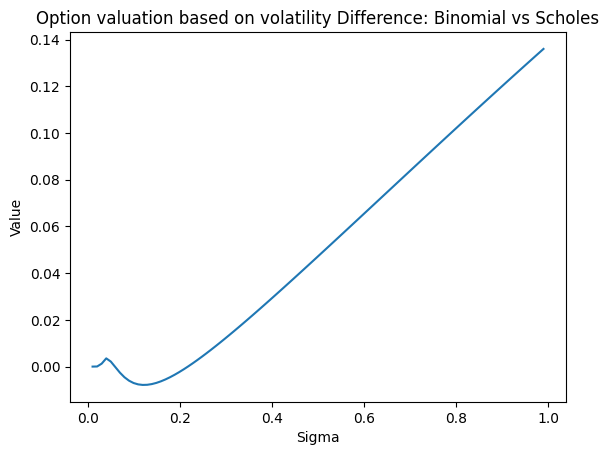

In [38]:
# Importing Black-Scholes calculations from part 3
from part3 import d1_d2, call_option_price

# calculate option price for each n in N
pricesBlackScholes = []
pricesBinomial = []
sigmas = np.linspace(0.01, 0.99, 100)
for sigma in sigmas:
    # Finding Black-Scholes valuation
    d1, d2 = d1_d2(S, K, r, sigma, T)
    tempPriceBlackScholes = call_option_price(S, K, r, T, d1, d2)
    pricesBlackScholes.append(tempPriceBlackScholes)
    # Finding Binomial Tree valuation
    treeN = buildTree(S, sigma, T, N)
    tempPriceBinomial = valueOptionMatrix(treeN, T, N, r, K, sigma)[0,0]
    pricesBinomial.append(tempPriceBinomial)

# Plotting multiple option valuations
plt.title("Option valuation based on volatility: Binomial vs Scholes")
plt.xlabel("Sigma")
plt.ylabel("Value")
plt.plot(sigmas, pricesBlackScholes, label ='Black-Scholes')
plt.plot(sigmas, pricesBinomial, label ='Binomial')
plt.legend()
plt.show()

# Plotting their difference
plt.title("Option valuation based on volatility Difference: Binomial vs Scholes")
plt.xlabel("Sigma")
plt.ylabel("Value")
difference = np.subtract(pricesBlackScholes, pricesBinomial)
plt.plot(sigmas, difference)
plt.show()

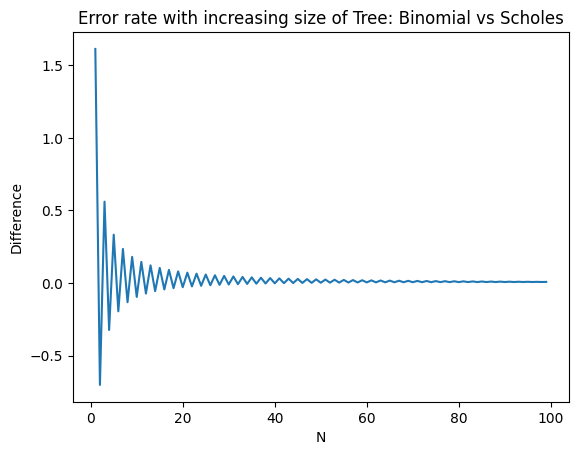

In [39]:
# Option params
sigma = 0.2
N_arr = np.arange(1, 100)  # Play around with different ranges of N and step sizes (1,300)

# Calculate the option price for the correct parameters
from part3 import d1_d2, call_option_price
d1, d2 = d1_d2(S, K, r, sigma, T)
optionPriceAnalytical = call_option_price(S, K, r, T, d1, d2)

# calculate option price for each n in N
priceApproximatedly = []
for n in N_arr:
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly.append(valueOptionMatrix(treeN, T, n, r, K, sigma)[0,0])

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.title("Error rate with increasing size of Tree: Binomial vs Scholes")
plt.xlabel("N")
plt.ylabel("Difference")
plt.plot(N_arr, [y-optionPriceAnalytical for y in priceApproximatedly])

In [40]:
# Hedge

# Create tree with risk neutral pricing
tree = buildTree(S, sigma, T, N)
down = tree[1, 0]
up = tree[1, 1]
# Find option value at each step
valueOptionMatrix(tree, T, N, r, K, sigma)
f_down = tree[1, 0]
f_up = tree[1, 1]
# Calculate hedge value in the begining
delta = (f_up-f_down)/(S*up-S*down)
print("Hedge: ", delta)

# Compare with Black-Scholes
from part3 import GBM_euler_mthod

stock_prices, call_option_prices, all_call_options_hedged_daily, put_option_prices, deltas, all_daily_deltas = GBM_euler_mthod(S, 365, N)
print(deltas)

Hedge:  0.00672556964604776
[0.9999999999999888, 0.9999999999993038, 0.9999999999660489, 0.9999999982364695, 0.9999998803103436, 0.9999927205932799, 0.99951741927714, 0.9551671930814495]
